# Part 5, Model 2B NN: Glaucoma Detection using a neural network on the fundus, optic cup and optic disk images of the eye + calculated OC feature + calculated OD feature using statistical analysis + selected patient details.

In [1]:
%pip install scikit-learn
%pip install seaborn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf

from pathlib import Path

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

2024-04-06 16:03:47.224998: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 16:03:47.225104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 16:03:47.246241: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-06 16:03:47.310255: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-06 16:03:48.487425: W tensorflow/compiler/tf2

In [3]:
tf.__version__

'2.15.0'

In [4]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('metadata - standardized.csv')

In [5]:
data.columns

Index(['names', 'types', 'type_expanded', 'isColor', 'original_name',
       'patient_id', 'fundus', 'fundus_od_seg', 'fundus_oc_seg', 'bv_seg',
       'artery_seg', 'vein_seg', 'oct', 'oct_oc_seg', 'oct_od_seg', 'sex',
       'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr',
       'Unnamed: 24', 'notchI_present', 'notchS_present', 'notchN_present',
       'notchT_present', 'expert1_grade', 'expert2_grade', 'expert3_grade',
       'expert4_grade', 'expert5_grade', 'cdr_avg', 'cdr_expert1',
       'cdr_expert2', 'cdr_expert3', 'cdr_expert4', 'refractive_dioptre_1',
       'refractive_dioptre_2', 'refractive_astigmatism',
       'phakic_or_pseudophakic', 'iop_perkins', 'iop_pneumatic', 'pachymetry',
       'axial_length', 'visual_field_mean_defect'],
      dtype='object')

In [6]:
data.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data['fundus_oc_seg'].dtype

dtype('O')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [9]:
print(data['fundus'][12044])
print(data['fundus_oc_seg'][12044])
print(data['fundus_od_seg'][12044])

/full-fundus/PAPILA-484.png
/optic-cup/PAPILA-484.png
/optic-disc/PAPILA-484.png


full-fundus/full-fundus/PAPILA-484.png


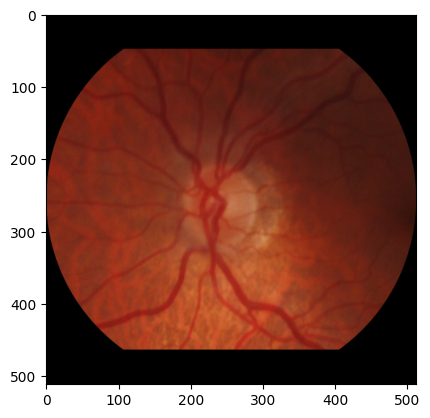

optic-cup/optic-cup/PAPILA-484.png


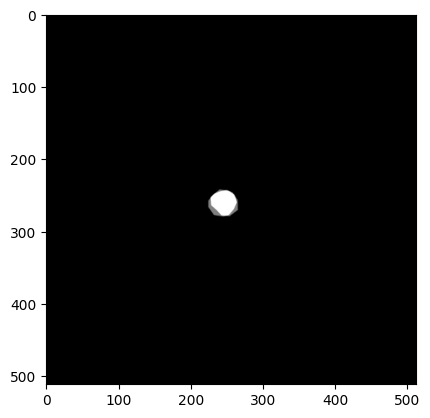

optic-disc/optic-disc/PAPILA-484.png


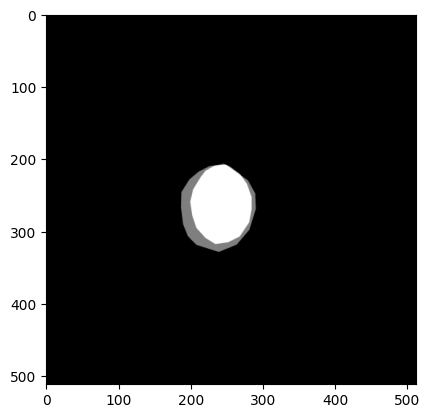

In [10]:
def viewFundus(image_path):

    image_path = 'full-fundus' + image_path

    print(image_path)

    image = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('on')
    plt.show()

def viewOpticCup(image_path):

    image_path = 'optic-cup' + image_path

    print(image_path)

    image = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('on')
    plt.show()

def viewOpticDisc(image_path):

    image_path = 'optic-disc' + image_path

    print(image_path)

    image = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('on')
    plt.show()


viewFundus(data['fundus'][12044])
viewOpticCup(data['fundus_oc_seg'][12044])
viewOpticDisc(data['fundus_od_seg'][12044])

In [11]:
data.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [13]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

data = data.dropna(axis=1, how='all')

data['eye'] = data['eye'].replace({'OD': 0, 'OS': 1})

for col in ['gender', 'eye']:
    if col in data.columns:
        mode = data[col].mode()[0]
        data[col] = data[col].fillna(mode)

numerical_data = data.select_dtypes(include=[np.number])

rf_regressor = RandomForestRegressor(
    n_estimators=150,
    max_features='sqrt',
    n_jobs=-1,
    random_state=None
)

imp = IterativeImputer(
    estimator=rf_regressor,
    max_iter=10,
    random_state=None
)

numerical_data_imputed = imp.fit_transform(numerical_data)

numerical_data_imputed = pd.DataFrame(numerical_data_imputed, columns=numerical_data.columns, index=numerical_data.index)

integer_columns = ['types', 'isColor', 'gender', 'eye', 'age']
for col in integer_columns:
    if col in numerical_data_imputed.columns:
        numerical_data_imputed[col] = numerical_data_imputed[col].round().astype('Int64')

non_numerical_data = data.select_dtypes(exclude=[np.number])
data_imputed = pd.concat([numerical_data_imputed, non_numerical_data], axis=1)

data_imputed = data_imputed.loc[data.index]

print("Shape of imputed data:", data_imputed.shape)

Shape of imputed data: (12449, 47)


/root/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [14]:
print(data_imputed.describe())

          types  isColor    gender        age       eye           sbp  \
count   12449.0  12449.0   12449.0    12449.0   12449.0  12449.000000   
mean   0.372239      1.0  0.985059  59.036951   0.77444    192.493686   
std    0.505039      0.0  0.121322   7.887071  0.417968     76.161017   
min        -1.0      1.0       0.0        1.0       0.0    107.000000   
25%         0.0      1.0       1.0       57.0       1.0    130.040000   
50%         0.0      1.0       1.0       62.0       1.0    149.953333   
75%         1.0      1.0       1.0       62.0       1.0    304.833333   
max         1.0      1.0       1.0       91.0       1.0    412.000000   

                dbp            hr           iop          vcdr  ...  \
count  12449.000000  12449.000000  12449.000000  12449.000000  ...   
mean      84.733385     69.337672     15.802157      0.595711  ...   
std        3.245161      3.372190      1.163524      0.079438  ...   
min       47.000000     51.000000      8.000000      0.161000 

In [15]:
data_imputed[["eye"]].value_counts()

eye
1      9641
0      2808
Name: count, dtype: int64

In [16]:
data = data_imputed

data

,types,isColor,gender,age,eye,sbp,dbp,hr,iop,vcdr,...,sex,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,0,1,1,58,0,305.393333,82.566667,66.060000,16.280000,0.474624,...,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,1,60,1,130.246667,83.866667,69.793333,17.453333,0.645662,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1,1,66,1,142.040000,87.993333,72.380000,17.266667,0.668568,...,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1,1,70,0,149.166667,88.860000,72.900000,17.526667,0.695485,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1,1,45,1,283.853333,82.846667,66.266667,15.720000,0.530454,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12444,0,1,1,57,1,304.853333,82.940000,66.226667,15.960000,0.491271,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12445,0,1,1,57,1,304.853333,82.940000,66.226667,15.960000,0.491271,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12446,0,1,1,57,1,304.853333,82.940000,66.226667,15.960000,0.491271,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12447,0,1,1,57,1,304.853333,82.940000,66.226667,15.960000,0.491271,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


optic-cup/optic-cup/PAPILA-484.png
optic-cup/optic-cup/PAPILA-484.png


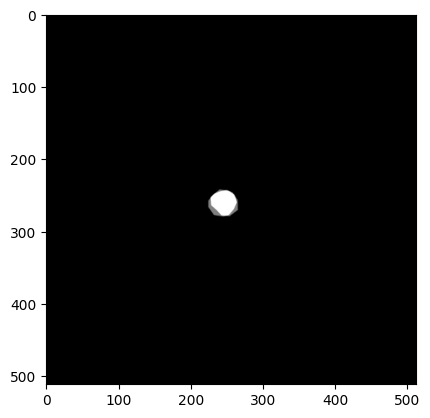

Normalized OC Area: 0.004856109619140625


In [17]:
import cv2
import numpy as np

def compute_normalized_area_optic_cup(masked_image_path):

    try:

        masked_image_path = 'optic-cup' + masked_image_path

        print(masked_image_path)

        masked_image = cv2.imread(masked_image_path)
        
        gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

        _, binary_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

        white_area = np.sum(binary_mask == 255)

        total_pixels = masked_image.shape[0] * masked_image.shape[1]
        
        normalized_area = white_area / total_pixels

        return normalized_area
    
    except Exception as e:
        
        print(f"Skipping: Error processing image at {masked_image_path}: {e}")
        return None

normalized_area = compute_normalized_area_optic_cup(data['fundus_oc_seg'][12044])

viewOpticCup(data['fundus_oc_seg'][12044])

print(f"Normalized OC Area: {normalized_area}")

optic-disc/optic-disc/PAPILA-484.png
optic-disc/optic-disc/PAPILA-484.png


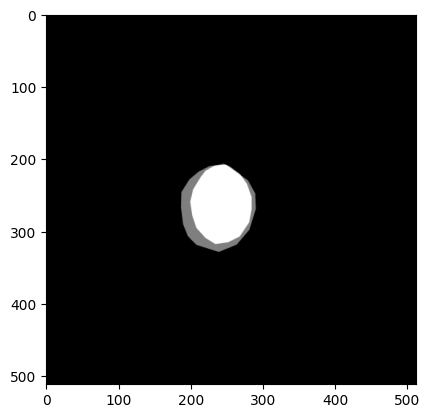

Normalized OD Area: 0.037567138671875


In [18]:
import cv2
import numpy as np

def compute_normalized_area_optic_disc(masked_image_path):

    try:

        masked_image_path = 'optic-disc' + masked_image_path

        print(masked_image_path)

        masked_image = cv2.imread(masked_image_path)
        
        gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

        _, binary_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

        white_area = np.sum(binary_mask == 255)

        total_pixels = masked_image.shape[0] * masked_image.shape[1]
        
        normalized_area = white_area / total_pixels

        return normalized_area
    
    except Exception as e:
        
        print(f"Skipping: Error processing image at {masked_image_path}: {e}")
        return None

normalized_area = compute_normalized_area_optic_disc(data['fundus_od_seg'][12044])

viewOpticDisc(data['fundus_od_seg'][12044])

print(f"Normalized OD Area: {normalized_area}")

In [19]:
import cv2
import numpy as np
import pandas as pd

data['OC size'] = 0.0

for index, row in data.iterrows():
    normalized_area = compute_normalized_area_optic_cup(row['fundus_oc_seg'])
    data.at[index, 'OC size'] = normalized_area

Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: ca

[ WARN:0@118.414] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@118.438] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@118.438] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@118.490] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@118.490] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@118.579] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-21.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-23.png
optic-cup/optic-cup/G1020-24.png
optic-cup/optic-cup/G1020-25.png
optic-cup/optic-cup/G1020-26.png
optic-cup/optic-cup/G1020-27.png
optic-cup/optic-cup/G1020-28.png
optic-cup/optic-cup/G1020-29.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-31.png
optic-cup/optic-cup/G1020-32.png
optic-cup/optic-cup/G1020-33.png
optic-cup/optic-cup/G1020-34.png
optic-cup/optic-cup/G1020-35.png
optic-cup/optic-cup/G1020-36.png
optic-cup/optic-cup/G1020-37.png


[ WARN:0@118.667] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@118.772] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-39.png
optic-cup/optic-cup/G1020-40.png
optic-cup/optic-cup/G1020-41.png
optic-cup/optic-cup/G1020-42.png
optic-cup/optic-cup/G1020-43.png
optic-cup/optic-cup/G1020-44.png
optic-cup/optic-cup/G1020-45.png
optic-cup/optic-cup/G1020-46.png
optic-cup/optic-cup/G1020-47.png
optic-cup/optic-cup/G1020-48.png
optic-cup/optic-cup/G1020-49.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/opt

[ WARN:0@118.912] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@118.913] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@118.938] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@118.975] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@119.018] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@119.032] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@119.032] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-59.png
optic-cup/optic-cup/G1020-60.png
optic-cup/optic-cup/G1020-61.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-63.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-66.png
opt

[ WARN:0@119.135] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@119.161] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@119.214] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@119.304] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@119.317] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@119.329] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@119.330] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-98.png
optic-cup/optic-cup/G1020-99.png
optic-cup/optic-cup/G1020-100.png
optic-cup/optic-cup/G1020-101.png
optic-cup/optic-cup/G1020-102.png
optic-cup/optic-cup/G1020-103.png
optic-cup/optic-cup/G1020-104.png
optic-cup/optic-cup/G1020-105.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-108.png
optic-cup/optic-cup/G1020-109.png
optic-cup/optic-cup/G1020-110.png
opti

[ WARN:0@119.344] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@119.450] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@119.451] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@119.502] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-117.png
optic-cup/optic-cup/G1020-118.png
optic-cup/optic-cup/G1020-119.png
optic-cup/optic-cup/G1020-120.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-122.png
optic-cup/optic-cup/G1020-123.png
optic-cup/optic-cup/G1020-124.png
optic-cup/optic-cup/G1020-125.png
optic-cup/optic-cup/G1020-126.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-128.png
optic-cup/optic-cup/G1020-129.png
optic-cup/optic-cup/G1020-130.png
optic-cup/optic-cup/G1020-131.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: err

[ WARN:0@119.602] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@119.664] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@119.713] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@119.738] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@119.738] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-143.png
optic-cup/optic-cup/G1020-144.png
optic-cup/optic-cup/G1020-145.png
optic-cup/optic-cup/G1020-146.png
optic-cup/optic-cup/G1020-147.png
optic-cup/optic-cup/G1020-148.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-151.png
optic-cup/optic-cup/G1020-152.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-154.png
optic-cup/optic-cup/G1020-155.png
optic-cupNot Visible
Skipping: Error

[ WARN:0@119.889] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@119.890] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@119.916] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@119.951] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@119.952] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@119.973] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@119.989] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@119.989] global loadsave.cpp:248 findDecoder i

optic-cup/optic-cup/G1020-166.png
optic-cup/optic-cup/G1020-167.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-169.png
optic-cup/optic-cup/G1020-170.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-173.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

[ WARN:0@120.140] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@120.141] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@120.142] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@120.281] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@120.332] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-189.png
optic-cup/optic-cup/G1020-190.png
optic-cup/optic-cup/G1020-191.png
optic-cup/optic-cup/G1020-192.png
optic-cup/optic-cup/G1020-193.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-195.png
optic-cup/optic-cup/G1020-196.png
optic-cup/optic-cup/G1020-197.png
optic-cup/optic-cup/G1020-198.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-200.png
optic-cup/optic-cup/G1020-201.png
optic-cup/optic-cup/G1020-202.png
optic-cup/optic-cup/G1020-203.png
optic-cup/optic-cup/G1020-204.png
optic-cup/optic-cup/G1020-205.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visi

[ WARN:0@120.414] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@120.441] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@120.475] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@120.490] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@120.503] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@120.517] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@120.576] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-226.png
optic-cup/optic-cup/G1020-227.png
optic-cup/optic-cup/G1020-228.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-230.png
optic-cup/optic-cup/G1020-231.png
optic-cup/optic-cup/G1020-232.png
optic-cup/optic-cup/G1020-233.png
optic-cup/optic-cup/G1020-234.png
optic-cup/optic-cup/G1020-235.png
optic-cup/optic-cup/G1020-236.png
optic-cup/optic-cup/G1020-237.png
optic-cup/optic-cup/G1020-238.png
optic-cup/optic-cup/G1020-239.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-241.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modu

[ WARN:0@120.627] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@120.751] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@120.763] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-246.png
optic-cup/optic-cup/G1020-247.png
optic-cup/optic-cup/G1020-248.png
optic-cup/optic-cup/G1020-249.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-253.png
optic-cup/optic-cup/G1020-254.png
optic-cup/optic-cup/G1020-255.png
optic-cup/optic-cup/G1020-256.png
optic-cup/optic-cup/G1020-257.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot 

[ WARN:0@120.854] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@120.854] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@120.855] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@120.916] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@121.001] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@121.014] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-273.png
optic-cup/optic-cup/G1020-274.png
optic-cup/optic-cup/G1020-275.png
optic-cup/optic-cup/G1020-276.png
optic-cup/optic-cup/G1020-277.png
optic-cup/optic-cup/G1020-278.png
optic-cup/optic-cup/G1020-279.png
optic-cup/optic-cup/G1020-280.png
optic-cup/optic-cup/G1020-281.png
optic-cup/optic-cup/G1020-282.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-284.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-286.png
optic-cup/optic-cup/G1020-287.png
optic-cup/optic-cup/G1020-288.png
optic-cup/optic-cup/G1020-289.png


[ WARN:0@121.208] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@121.222] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@121.322] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@121.336] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-290.png
optic-cup/optic-cup/G1020-291.png
optic-cup/optic-cup/G1020-292.png
optic-cup/optic-cup/G1020-293.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-295.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-297.png
optic-cup/optic-cup/G1020-298.png
optic-cup/optic-cup/G1020-299.png
optic-cup/optic-cup/G1020-300.png
optic-cup/optic-cup/G1020-301.png
optic-cup/optic-cup/G1020-302.png
optic-cup/optic-cup/G1020-303.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.

[ WARN:0@121.426] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@121.607] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-323.png
optic-cup/optic-cup/G1020-324.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-326.png
optic-cup/optic-cup/G1020-327.png
optic-cup/optic-cup/G1020-328.png
optic-cup/optic-cup/G1020-329.png
optic-cup/optic-cup/G1020-330.png
optic-cup/optic-cup/G1020-331.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-333.png
optic-cup/optic-cup/G1020-334.png
optic-cup/optic-cup/G1020-335.png
optic-cup/optic-cup/G1020-336.png
optic-cup/optic-cup/G1020-337.png
optic-cup/optic-cup/G1020-338.png
optic-cup/optic-cup/G1020-339.png
optic-cup/optic-cup/G1020-340.png
optic-cup/optic-cup/G1020-341.png


[ WARN:0@121.659] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@121.733] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-342.png
optic-cup/optic-cup/G1020-343.png
optic-cup/optic-cup/G1020-344.png
optic-cup/optic-cup/G1020-345.png
optic-cup/optic-cup/G1020-346.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-348.png
optic-cup/optic-cup/G1020-349.png
optic-cup/optic-cup/G1020-350.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-353.png
optic-cup/optic-cup/G1020-354.png
optic-cup/optic-cup/G1020-355.png
op

[ WARN:0@121.908] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@121.947] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@121.947] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-365.png
optic-cup/optic-cup/G1020-366.png
optic-cup/optic-cup/G1020-367.png
optic-cup/optic-cup/G1020-368.png
optic-cup/optic-cup/G1020-369.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-371.png
optic-cup/optic-cup/G1020-372.png
optic-cup/optic-cup/G1020-373.png
optic-cup/optic-cup/G1020-374.png
optic-cup/optic-cup/G1020-375.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-377.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

op

[ WARN:0@122.177] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@122.236] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@122.249] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@122.299] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@122.336] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@122.349] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-385.png
optic-cup/optic-cup/G1020-386.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-388.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-390.png
optic-cup/optic-cup/G1020-391.png
optic-cup/optic-cup/G1020-392.png
optic-cup/optic-cup/G1020-393.png
optic-cup/optic-cup/G1020-394.png
optic-cup/optic-cup/G1020-395.png
optic-cup/optic-cup/G1020-396.png
optic-cup/optic-cup/G1020-397.png
optic-cup/optic-cup/G1020-398.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.

[ WARN:0@122.463] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@122.464] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@122.501] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@122.527] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@122.551] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@122.599] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-421.png
optic-cup/optic-cup/G1020-422.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-424.png
optic-cup/optic-cup/G1020-425.png
optic-cup/optic-cup/G1020-426.png
optic-cup/optic-cup/G1020-427.png
optic-cup/optic-cup/G1020-428.png
optic-cup/optic-cup/G1020-429.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-431.png
optic-cup/optic-cup/G1020-432.png
optic-cup/optic-cup/G1020-433.png
optic-cup/optic-cup/G1020-434.png
optic-cup/optic-cup/G1020-435.png
optic-cup/optic-cup/G1020-436.png
optic-cup/optic-cup/G1020-437.png
optic-cupNot Visible


[ WARN:0@122.686] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@122.771] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@122.861] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-439.png
optic-cup/optic-cup/G1020-440.png
optic-cup/optic-cup/G1020-441.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-443.png
optic-cup/optic-cup/G1020-444.png
optic-cup/optic-cup/G1020-445.png
optic-cup/optic-cup/G1020-446.png
optic-cup/optic-cup/G1020-447.png
optic-cup/optic-cup/G1020-448.png
optic-cup/optic-cup/G1020-449.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-451.png
optic-cup/optic-cup/G10

[ WARN:0@122.902] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@122.991] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.016] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.030] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.031] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.043] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.093] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-461.png
optic-cup/optic-cup/G1020-462.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-464.png
optic-cup/optic-cup/G1020-465.png
optic-cup/optic-cup/G1020-466.png
optic-cup/optic-cup/G1020-467.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-469.png
optic-cup/optic-cup/G1020-470.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-472.png
optic-cup/optic-cup/G1020-473.png
optic-cupNot Visible
Skipping: Error

[ WARN:0@123.148] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.174] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.200] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.297] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.298] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.335] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.336] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.348] global loadsave.cpp:248 findDecoder i

Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-490.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-492.png
optic-cup/optic-cup/G1020-493.png
optic-cup/optic-cup/G1020-494.png
optic-cup/optic-cup/G1020-495.png
optic-cup/optic-cup/G1020-496.png
optic-cup/optic-cup/G1020-497.png
optic-cup/optic-cup/G1020-498.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/c

[ WARN:0@123.441] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.442] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.442] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.505] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.505] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.544] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.557] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.570] global loadsave.cpp:248 findDecoder i

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-513.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-515.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-518.png
optic-cup/optic-cup/G1020-519.png
optic-cup/optic-cup/G1020-520.pn

[ WARN:0@123.657] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.657] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.737] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.738] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.739] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-536.png
optic-cup/optic-cup/G1020-537.png
optic-cup/optic-cup/G1020-538.png
optic-cup/optic-cup/G1020-539.png
optic-cup/optic-cup/G1020-540.png
optic-cup/optic-cup/G1020-541.png
optic-cup/optic-cup/G1020-542.png
optic-cup/optic-cup/G1020-543.png
optic-cup/optic-cup/G1020-544.png
optic-cup/optic-cup/G1020-545.png
optic-cup/optic-cup/G1020-546.png
optic-cup/optic-cup/G1020-547.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-549.png
optic-cup/optic-cup/G1020-550.png
optic-cup/optic-cup/G1020-551.png
optic-cup/optic-cup/G1020-552.png
optic-cup/optic-cup/G1020-553.png
optic-cup/optic-cup/G1020-554.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empt

[ WARN:0@123.903] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.979] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.992] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.992] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.993] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@123.993] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@124.031] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@124.032] global loadsave.cpp:248 findDecoder i

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed

[ WARN:0@124.106] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@124.107] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@124.108] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@124.108] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@124.109] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@124.137] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@124.138] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@124.261] global loadsave.cpp:248 findDecoder i

optic-cup/optic-cup/G1020-599.png
optic-cup/optic-cup/G1020-600.png
optic-cup/optic-cup/G1020-601.png
optic-cup/optic-cup/G1020-602.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-605.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-607.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_

[ WARN:0@124.362] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@124.363] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@124.376] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@124.389] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@124.463] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@124.512] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-622.png
optic-cup/optic-cup/G1020-623.png
optic-cup/optic-cup/G1020-624.png
optic-cup/optic-cup/G1020-625.png
optic-cup/optic-cup/G1020-626.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-628.png
optic-cup/optic-cup/G1020-629.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-631.png
optic-cup/optic-cup/G1020-632.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-634.png
optic-cup/optic-cup/G1020-635.png
op

[ WARN:0@124.593] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@124.628] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@124.656] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@124.756] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@124.768] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@124.768] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@124.781] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-650.png
optic-cup/optic-cup/G1020-651.png
optic-cup/optic-cup/G1020-652.png
optic-cup/optic-cup/G1020-653.png
optic-cup/optic-cup/G1020-654.png
optic-cup/optic-cup/G1020-655.png
optic-cup/optic-cup/G1020-656.png
optic-cup/optic-cup/G1020-657.png
optic-cup/optic-cup/G1020-658.png
optic-cup/optic-cup/G1020-659.png
optic-cup/optic-cup/G1020-660.png
optic-cup/optic-cup/G1020-661.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-663.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-665.png
optic-cup/optic-cup/G1020-666.png
optic-cup/optic-cup/G1020-667.png
optic-cup/optic-cup/G1020-668.png
optic-

[ WARN:0@124.953] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@124.965] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@125.026] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@125.053] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@125.068] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@125.132] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-683.png
optic-cup/optic-cup/G1020-684.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-686.png
optic-cup/optic-cup/G1020-687.png
optic-cup/optic-cup/G1020-688.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-691.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_

[ WARN:0@125.175] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@125.211] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@125.212] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@125.225] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@125.239] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@125.339] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@125.353] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@125.353] global loadsave.cpp:248 findDecoder i

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-707.png
optic-cup/optic-cup/G1020-708.png
optic-cup/optic-cup/G1020-709.png
optic-cup/optic-cup/G1020-710.png
optic-cup/optic-cup/G1020-711.png
optic-cup/optic-cup/G1020-712.png
optic-cup/optic-cup/G1020-713.png
optic-cup/optic-cup/G1020-714.png
optic-cup/optic-cup/G1020-715.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-717.png
optic-cupNot Visible
Skipping: Error

[ WARN:0@125.484] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@125.501] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-730.png
optic-cup/optic-cup/G1020-731.png
optic-cup/optic-cup/G1020-732.png
optic-cup/optic-cup/G1020-733.png
optic-cup/optic-cup/G1020-734.png
optic-cup/optic-cup/G1020-735.png
optic-cup/optic-cup/G1020-736.png
optic-cup/optic-cup/G1020-737.png
optic-cup/optic-cup/G1020-738.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-740.png
optic-cup/optic-cup/G1020-741.png
optic-cup/optic-cup/G1020-742.png
optic-cup/optic-cup/G1020-743.png
optic-cup/optic-cup/G1020-744.png
optic-cup/optic-cup/G1020-745.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-747.png


[ WARN:0@125.756] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@125.834] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@125.861] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@125.898] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@125.899] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@125.900] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-748.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-750.png
optic-cup/optic-cup/G1020-751.png
optic-cup/optic-cup/G1020-752.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-756.pn

[ WARN:0@125.978] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@125.979] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@126.018] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@126.031] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@126.079] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@126.093] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@126.144] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-786.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-789.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-791.png
optic-cupNot Visible
Skipping: Error processing image at optic-cup

[ WARN:0@126.183] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@126.198] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@126.198] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@126.212] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@126.229] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@126.324] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-805.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-807.png
optic-cup/optic-cup/G1020-808.png
optic-cup/optic-cup/G1020-809.png
optic-cup/optic-cup/G1020-810.png
optic-cup/optic-cup/G1020-811.png
optic-cup/optic-cup/G1020-812.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-814.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-816.png
optic-cup/optic-cup/G1020-817.png
optic-cup/optic-cup/G1020-818.png
op

[ WARN:0@126.400] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@126.480] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@126.496] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@126.532] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@126.582] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-826.png
optic-cup/optic-cup/G1020-827.png
optic-cup/optic-cup/G1020-828.png
optic-cup/optic-cup/G1020-829.png
optic-cup/optic-cup/G1020-830.png
optic-cup/optic-cup/G1020-831.png
optic-cup/optic-cup/G1020-832.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-834.png
optic-cup/optic-cup/G1020-835.png
optic-cup/optic-cup/G1020-836.png
optic-cup/optic-cup/G1020-837.png
optic-cup/optic-cup/G1020-838.png
optic-cup/optic-cup/G1020-839.png
optic-cup/optic-cup/G1020-840.png
optic-cup/optic-cup/G1020-841.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-843.png
optic-cupNot Visible
Skipping: Error pro

[ WARN:0@126.684] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@126.787] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@126.801] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@126.863] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-854.png
optic-cup/optic-cup/G1020-855.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-857.png
optic-cup/optic-cup/G1020-858.png
optic-cup/optic-cup/G1020-859.png
optic-cup/optic-cup/G1020-860.png
optic-cup/optic-cup/G1020-861.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-863.png
optic-cup/optic-cup/G1020-864.png
optic-cup/optic-cup/G1020-865.png
optic-cup/optic-cup/G1020-866.png
op

[ WARN:0@126.891] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@126.926] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@126.994] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-871.png
optic-cup/optic-cup/G1020-872.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-874.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-876.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-879.pn

[ WARN:0@127.121] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@127.133] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@127.146] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@127.147] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@127.159] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@127.206] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@127.207] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@127.233] global loadsave.cpp:248 findDecoder i

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-897.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-899.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-901.png
optic-cup/optic-cup/G1020-902.png
optic-cup/optic-cup/G1020-903.png
optic-cup/optic-cup/G1020-904.png
optic-cup/optic-cup/G1020-905.png
optic-cup/optic-cup/G1020-906.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/

[ WARN:0@127.329] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@127.403] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-916.png
optic-cup/optic-cup/G1020-917.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-920.png
optic-cup/optic-cup/G1020-921.png
optic-cup/optic-cup/G1020-922.png
optic-cup/optic-cup/G1020-923.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-925.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182:

[ WARN:0@127.531] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@127.532] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@127.577] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@127.589] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@127.612] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@127.691] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@127.703] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-939.png
optic-cup/optic-cup/G1020-940.png
optic-cup/optic-cup/G1020-941.png
optic-cup/optic-cup/G1020-942.png
optic-cup/optic-cup/G1020-943.png
optic-cup/optic-cup/G1020-944.png
optic-cup/optic-cup/G1020-945.png
optic-cup/optic-cup/G1020-946.png
optic-cup/optic-cup/G1020-947.png
optic-cup/optic-cup/G1020-948.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-950.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-952.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.

[ WARN:0@127.834] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@127.848] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@127.860] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@127.895] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@127.909] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@128.016] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-972.png
optic-cup/optic-cup/G1020-973.png
optic-cup/optic-cup/G1020-974.png
optic-cup/optic-cup/G1020-975.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-977.png
optic-cup/optic-cup/G1020-978.png
optic-cup/optic-cup/G1020-979.png
optic-cup/optic-cup/G1020-980.png
optic-cup/optic-cup/G1020-981.png
optic-cup/optic-cup/G1020-982.png
optic-cup/optic-cup/G1020-983.png
optic-cup/optic-cup/G1020-984.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-986.png
optic-cup/optic-cup/G1020-987.png
optic-cup/optic-cup/G1020-988.png
optic-cup/optic-cup/G1020-989.png


[ WARN:0@128.093] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@128.199] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@128.251] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-991.png
optic-cup/optic-cup/G1020-992.png
optic-cup/optic-cup/G1020-993.png
optic-cup/optic-cup/G1020-994.png
optic-cup/optic-cup/G1020-995.png
optic-cup/optic-cup/G1020-996.png
optic-cup/optic-cup/G1020-997.png
optic-cup/optic-cup/G1020-998.png
optic-cup/optic-cup/G1020-999.png
optic-cup/optic-cup/G1020-1000.png
optic-cup/optic-cup/G1020-1001.png
optic-cup/optic-cup/G1020-1002.png
optic-cup/optic-cup/G1020-1003.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

optic-cup/optic-cup/G1020-1005.png
optic-cup/optic-cup/G1020-1006.png
optic-cup/optic-cup/G1020-1007.png
optic-cup/optic-cup/G1020-1008.pn

[ WARN:0@128.429] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@128.493] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity
[ WARN:0@128.602] global loadsave.cpp:248 findDecoder imread_('optic-cupNot Visible'): can't open/read file: check file path/integrity


optic-cup/optic-cup/G1020-1015.png
optic-cup/optic-cup/G1020-1016.png
optic-cup/optic-cup/G1020-1017.png
optic-cup/optic-cup/G1020-1018.png
optic-cup/optic-cup/G1020-1019.png
optic-cupNot Visible
Skipping: Error processing image at optic-cupNot Visible: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping

In [20]:
import cv2
import numpy as np
import pandas as pd

data['OD size'] = 0.0  

for index, row in data.iterrows():
    normalized_area = compute_normalized_area_optic_disc(row['fundus_od_seg'])
    data.at[index, 'OD size'] = normalized_area

Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: can only concatenate str (not "float") to str
Skipping: Error processing image at nan: ca

In [21]:
data = data [

    (data['fundus'].notnull()) &
    (data['fundus_oc_seg'].notnull()) & 
    (data['fundus_od_seg'].notnull()) & (data['types'] != -1)
]

fundus_subset = data[['types', 'fundus', 'fundus_oc_seg', 'fundus_od_seg', 'names', 'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size']]

fundus_subset['combined'] = fundus_subset['names'] + '.png'

fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)

fundus_subset['types'] = fundus_subset['types'].astype(str)

fundus_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3034 entries, 4546 to 12048
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   types          3034 non-null   object 
 1   fundus         3034 non-null   object 
 2   fundus_oc_seg  3034 non-null   object 
 3   fundus_od_seg  3034 non-null   object 
 4   names          3034 non-null   object 
 5   gender         3034 non-null   Int64  
 6   age            3034 non-null   Int64  
 7   eye            3034 non-null   Int64  
 8   sbp            3034 non-null   float64
 9   dbp            3034 non-null   float64
 10  hr             3034 non-null   float64
 11  iop            3034 non-null   float64
 12  vcdr           3034 non-null   float64
 13  cdr_avg        3034 non-null   float64
 14  OC size        2805 non-null   float64
 15  OD size        3034 non-null   float64
 16  combined       3034 non-null   object 
dtypes: Int64(3), float64(8), object(6)
memory usage: 435.

/tmp/ipykernel_20248/2242382284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundus_subset['combined'] = fundus_subset['names'] + '.png'
/tmp/ipykernel_20248/2242382284.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)
/tmp/ipykernel_20248/2242382284.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [22]:
fundus_subset['types'].value_counts()

types
0    2310
1     724
Name: count, dtype: int64

In [23]:
fundus_subset[fundus_subset['fundus_oc_seg'] == 'Not Visible']

,types,fundus,fundus_oc_seg,fundus_od_seg,names,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,OC size,OD size,combined
7276,0,/full-fundus/G1020-5.png,Not Visible,/optic-disc/G1020-5.png,G1020-5,1,57,1,304.853333,82.940000,66.226667,15.96,0.491271,0.528933,NaN,0.015846,G1020-5.png
7278,0,/full-fundus/G1020-7.png,Not Visible,/optic-disc/G1020-7.png,G1020-7,1,57,1,304.853333,82.940000,66.226667,15.96,0.491271,0.528933,NaN,0.013840,G1020-7.png
7279,0,/full-fundus/G1020-8.png,Not Visible,/optic-disc/G1020-8.png,G1020-8,1,57,1,304.853333,82.940000,66.226667,15.96,0.491271,0.528933,NaN,0.021877,G1020-8.png
7284,1,/full-fundus/G1020-13.png,Not Visible,/optic-disc/G1020-13.png,G1020-13,1,62,1,130.040000,86.433333,71.900000,15.02,0.648682,0.741433,NaN,0.014683,G1020-13.png
7285,1,/full-fundus/G1020-14.png,Not Visible,/optic-disc/G1020-14.png,G1020-14,1,62,1,130.040000,86.433333,71.900000,15.02,0.648682,0.741433,NaN,0.023487,G1020-14.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8256,1,/full-fundus/G1020-985.png,Not Visible,/optic-disc/G1020-985.png,G1020-985,1,62,1,130.040000,86.433333,71.900000,15.02,0.648682,0.741433,NaN,0.016605,G1020-985.png
8261,0,/full-fundus/G1020-990.png,Not Visible,/optic-disc/G1020-990.png,G1020-990,1,57,1,304.853333,82.940000,66.226667,15.96,0.491271,0.528933,NaN,0.015263,G1020-990.png
8275,1,/full-fundus/G1020-1004.png,Not Visible,/optic-disc/G1020-1004.png,G1020-1004,1,62,1,130.040000,86.433333,71.900000,15.02,0.648682,0.741433,NaN,0.026836,G1020-1004.png
8281,0,/full-fundus/G1020-1010.png,Not Visible,/optic-disc/G1020-1010.png,G1020-1010,1,57,1,304.853333,82.940000,66.226667,15.96,0.491271,0.528933,NaN,0.016308,G1020-1010.png


In [24]:
fundus_subset = fundus_subset[fundus_subset['fundus_oc_seg'] != 'Not Visible']

In [25]:
fundus_subset

,types,fundus,fundus_oc_seg,fundus_od_seg,names,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,OC size,OD size,combined
4546,0,/full-fundus/ORIGA-1.png,/optic-cup/ORIGA-1.png,/optic-disc/ORIGA-1.png,ORIGA-1,1,71,0,149.460000,89.000000,73.266667,17.346667,0.709700,0.738850,0.010849,0.022560,ORIGA-1.png
4547,0,/full-fundus/ORIGA-2.png,/optic-cup/ORIGA-2.png,/optic-disc/ORIGA-2.png,ORIGA-2,1,71,1,150.086667,88.820000,73.600000,17.426667,0.695300,0.739150,0.010250,0.020405,ORIGA-2.png
4548,0,/full-fundus/ORIGA-3.png,/optic-cup/ORIGA-3.png,/optic-disc/ORIGA-3.png,ORIGA-3,1,73,1,150.420000,89.600000,74.780000,18.160000,0.962900,0.740367,0.019222,0.020947,ORIGA-3.png
4549,0,/full-fundus/ORIGA-4.png,/optic-cup/ORIGA-4.png,/optic-disc/ORIGA-4.png,ORIGA-4,1,72,0,149.946667,89.133333,73.733333,17.853333,0.724600,0.739150,0.008072,0.015347,ORIGA-4.png
4550,0,/full-fundus/ORIGA-5.png,/optic-cup/ORIGA-5.png,/optic-disc/ORIGA-5.png,ORIGA-5,1,52,1,129.326667,83.573333,69.226667,16.260000,0.613800,0.713983,0.008331,0.018131,ORIGA-5.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12044,0,/full-fundus/PAPILA-484.png,/optic-cup/PAPILA-484.png,/optic-disc/PAPILA-484.png,PAPILA-484,0,64,1,136.020000,87.060000,72.280000,17.693333,0.661147,0.733050,0.004856,0.037567,PAPILA-484.png
12045,0,/full-fundus/PAPILA-485.png,/optic-cup/PAPILA-485.png,/optic-disc/PAPILA-485.png,PAPILA-485,1,75,1,150.553333,88.866667,74.680000,17.546667,0.756484,0.743033,0.004936,0.039188,PAPILA-485.png
12046,0,/full-fundus/PAPILA-486.png,/optic-cup/PAPILA-486.png,/optic-disc/PAPILA-486.png,PAPILA-486,0,55,1,242.093333,82.586667,66.533333,15.940000,0.541527,0.654217,0.002399,0.024658,PAPILA-486.png
12047,0,/full-fundus/PAPILA-487.png,/optic-cup/PAPILA-487.png,/optic-disc/PAPILA-487.png,PAPILA-487,1,56,1,276.406667,82.606667,66.526667,16.406667,0.535573,0.614617,0.006138,0.028481,PAPILA-487.png


In [26]:
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit

glaucomaCount = len(fundus_subset[fundus_subset['types'] == '1'])
healthyCount = len(fundus_subset[fundus_subset['types'] == '0'])

print("this is the glaucoma count", glaucomaCount)
print("this is the healthy eyes count", healthyCount)

test_percentage = 0.10
val_percentage_from_train = 0.05

class_weights = class_weight.compute_class_weight(
                class_weight='balanced',
                classes=np.unique(fundus_subset['types']),
                y=fundus_subset['types'].values)

class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

random_state = 1

stratified_split_test = StratifiedShuffleSplit(n_splits=1, test_size=test_percentage, random_state=random_state)

for train_index, test_index in stratified_split_test.split(fundus_subset, fundus_subset['types']):
    train_set_temp = fundus_subset.iloc[train_index]
    test = fundus_subset.iloc[test_index]

stratified_split_val = StratifiedShuffleSplit(n_splits=1, test_size=val_percentage_from_train, random_state=random_state)

for train_index, val_index in stratified_split_val.split(train_set_temp, train_set_temp['types']):
    train = train_set_temp.iloc[train_index]
    val = train_set_temp.iloc[val_index]

print("\nTotal fundus images to be used:", len(fundus_subset))
print("\nTrain set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

print("\nClass weights for model training:")
print(class_weights_dict)

train_features = train.drop('types', axis=1)
train_labels = train['types']
val_features = val.drop('types', axis=1)
val_labels = val['types']
test_features = test.drop('types', axis=1)
test_labels = test['types']

this is the glaucoma count 665
this is the healthy eyes count 2140

Total fundus images to be used: 2805

Train set size: 2397
Validation set size: 127
Test set size: 281

Class weights for model training:
{0: 0.655373831775701, 1: 2.1090225563909772}


In [27]:
print("Train Size: ", len(train))
print("Test Size: ", len(test))

Train Size:  2397
Test Size:  281


In [28]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-06 16:06:45.721578: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 16:06:46.039976: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 16:06:46.040408: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [29]:
train

,types,fundus,fundus_oc_seg,fundus_od_seg,names,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,OC size,OD size,combined
4849,1,/full-fundus/ORIGA-304.png,/optic-cup/ORIGA-304.png,/optic-disc/ORIGA-304.png,ORIGA-304,1,70,1,154.693333,70.813333,56.673333,10.160000,0.617700,0.806583,0.006584,0.016487,ORIGA-304.png
5087,0,/full-fundus/ORIGA-542.png,/optic-cup/ORIGA-542.png,/optic-disc/ORIGA-542.png,ORIGA-542,1,54,0,151.073333,83.746667,68.686667,16.426667,0.597500,0.714367,0.004414,0.012852,ORIGA-542.png
7508,0,/full-fundus/G1020-237.png,/optic-cup/G1020-237.png,/optic-disc/G1020-237.png,G1020-237,1,57,1,304.853333,82.940000,66.226667,15.960000,0.491271,0.528933,0.002846,0.019154,G1020-237.png
5052,1,/full-fundus/ORIGA-507.png,/optic-cup/ORIGA-507.png,/optic-disc/ORIGA-507.png,ORIGA-507,1,67,0,137.600000,88.080000,75.180000,16.820000,0.814600,0.741000,0.008698,0.014595,ORIGA-507.png
4585,0,/full-fundus/ORIGA-40.png,/optic-cup/ORIGA-40.png,/optic-disc/ORIGA-40.png,ORIGA-40,1,57,1,129.640000,83.766667,69.813333,17.513333,0.641700,0.717267,0.003971,0.011936,ORIGA-40.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7269,0,/full-fundus/REFUGE1-val-398.png,/optic-cup/REFUGE1-val-398.png,/optic-disc/REFUGE1-val-398.png,REFUGE1-val-398,1,57,1,304.853333,82.940000,66.226667,15.960000,0.491271,0.528933,0.011017,0.027203,REFUGE1-val-398.png
4854,0,/full-fundus/ORIGA-309.png,/optic-cup/ORIGA-309.png,/optic-disc/ORIGA-309.png,ORIGA-309,1,46,0,157.826667,85.620000,68.326667,16.306667,0.571900,0.701917,0.004490,0.012413,ORIGA-309.png
4659,0,/full-fundus/ORIGA-114.png,/optic-cup/ORIGA-114.png,/optic-disc/ORIGA-114.png,ORIGA-114,1,58,1,305.153333,82.413333,66.546667,16.206667,0.479200,0.516633,0.004906,0.017006,ORIGA-114.png
11746,0,/full-fundus/PAPILA-186.png,/optic-cup/PAPILA-186.png,/optic-disc/PAPILA-186.png,PAPILA-186,1,79,0,152.513333,89.293333,74.760000,18.706667,0.754571,0.736250,0.001019,0.030647,PAPILA-186.png


In [30]:
val

,types,fundus,fundus_oc_seg,fundus_od_seg,names,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,OC size,OD size,combined
7985,0,/full-fundus/G1020-714.png,/optic-cup/G1020-714.png,/optic-disc/G1020-714.png,G1020-714,1,57,1,304.853333,82.940000,66.226667,15.960000,0.491271,0.528933,0.002312,0.025490,G1020-714.png
7773,0,/full-fundus/G1020-502.png,/optic-cup/G1020-502.png,/optic-disc/G1020-502.png,G1020-502,1,57,1,304.853333,82.940000,66.226667,15.960000,0.491271,0.528933,0.002323,0.012783,G1020-502.png
5179,1,/full-fundus/ORIGA-634.png,/optic-cup/ORIGA-634.png,/optic-disc/ORIGA-634.png,ORIGA-634,1,51,1,178.420000,83.520000,69.066667,14.193333,0.513700,0.686350,0.004509,0.017616,ORIGA-634.png
11814,1,/full-fundus/PAPILA-254.png,/optic-cup/PAPILA-254.png,/optic-disc/PAPILA-254.png,PAPILA-254,1,60,1,128.713333,85.066667,71.486667,13.486667,0.628905,0.742467,0.012932,0.027107,PAPILA-254.png
6937,0,/full-fundus/REFUGE1-val-66.png,/optic-cup/REFUGE1-val-66.png,/optic-disc/REFUGE1-val-66.png,REFUGE1-val-66,1,57,1,304.853333,82.940000,66.226667,15.960000,0.491271,0.528933,0.004730,0.018055,REFUGE1-val-66.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6824,0,/full-fundus/DRISHTI-GS1-train-3.png,/optic-cup/DRISHTI-GS1-train-3.png,/optic-disc/DRISHTI-GS1-train-3.png,DRISHTI-GS1-train-3,1,54,1,259.153333,81.940000,66.626667,15.326667,0.475017,0.572500,0.013077,0.025589,DRISHTI-GS1-train-3.png
7818,0,/full-fundus/G1020-547.png,/optic-cup/G1020-547.png,/optic-disc/G1020-547.png,G1020-547,1,57,1,304.853333,82.940000,66.226667,15.960000,0.491271,0.528933,0.008949,0.023537,G1020-547.png
6489,0,/full-fundus/REFUGE1-train-259.png,/optic-cup/REFUGE1-train-259.png,/optic-disc/REFUGE1-train-259.png,REFUGE1-train-259,1,57,1,304.853333,82.940000,66.226667,15.960000,0.491271,0.528933,0.004341,0.012939,REFUGE1-train-259.png
6650,1,/full-fundus/CRFO-v4-10.png,/optic-cup/CRFO-v4-10.png,/optic-disc/CRFO-v4-10.png,CRFO-v4-10,1,62,1,130.040000,86.433333,71.900000,15.020000,0.648682,0.741433,0.009708,0.013771,CRFO-v4-10.png


In [31]:
test

,types,fundus,fundus_oc_seg,fundus_od_seg,names,gender,age,eye,sbp,dbp,hr,iop,vcdr,cdr_avg,OC size,OD size,combined
11992,1,/full-fundus/PAPILA-432.png,/optic-cup/PAPILA-432.png,/optic-disc/PAPILA-432.png,PAPILA-432,1,70,1,156.606667,64.280000,53.573333,9.800000,0.621223,0.837700,0.005604,0.035595,PAPILA-432.png
7104,0,/full-fundus/REFUGE1-val-233.png,/optic-cup/REFUGE1-val-233.png,/optic-disc/REFUGE1-val-233.png,REFUGE1-val-233,1,57,1,304.853333,82.940000,66.226667,15.960000,0.491271,0.528933,0.005268,0.021210,REFUGE1-val-233.png
7984,0,/full-fundus/G1020-713.png,/optic-cup/G1020-713.png,/optic-disc/G1020-713.png,G1020-713,1,57,1,304.853333,82.940000,66.226667,15.960000,0.491271,0.528933,0.003498,0.017590,G1020-713.png
6690,0,/full-fundus/CRFO-v4-50.png,/optic-cup/CRFO-v4-50.png,/optic-disc/CRFO-v4-50.png,CRFO-v4-50,1,56,0,159.240000,83.653333,66.893333,15.673333,0.561989,0.708000,0.005947,0.017834,CRFO-v4-50.png
4566,0,/full-fundus/ORIGA-21.png,/optic-cup/ORIGA-21.png,/optic-disc/ORIGA-21.png,ORIGA-21,1,55,1,159.846667,83.066667,68.286667,16.073333,0.562100,0.711750,0.007526,0.018803,ORIGA-21.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6485,0,/full-fundus/REFUGE1-train-255.png,/optic-cup/REFUGE1-train-255.png,/optic-disc/REFUGE1-train-255.png,REFUGE1-train-255,1,57,1,304.853333,82.940000,66.226667,15.960000,0.491271,0.528933,0.006058,0.019344,REFUGE1-train-255.png
6891,0,/full-fundus/REFUGE1-val-20.png,/optic-cup/REFUGE1-val-20.png,/optic-disc/REFUGE1-val-20.png,REFUGE1-val-20,1,57,1,304.853333,82.940000,66.226667,15.960000,0.491271,0.528933,0.003693,0.016857,REFUGE1-val-20.png
4754,0,/full-fundus/ORIGA-209.png,/optic-cup/ORIGA-209.png,/optic-disc/ORIGA-209.png,ORIGA-209,1,57,1,304.853333,82.826667,66.206667,15.946667,0.493300,0.527583,0.005001,0.015141,ORIGA-209.png
11665,0,/full-fundus/PAPILA-105.png,/optic-cup/PAPILA-105.png,/optic-disc/PAPILA-105.png,PAPILA-105,1,64,0,135.666667,87.086667,71.940000,17.606667,0.659866,0.733550,0.000671,0.027008,PAPILA-105.png


In [32]:
import tensorflow as tf
from tensorflow import keras
from keras.layers.experimental.preprocessing import Rescaling
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 


target = 224
batchSize = 1

classes = 'binary'

with tf.device('/GPU:0'):


    trainDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen1 = trainDataGen1.flow_from_dataframe(dataframe=train, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    valDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen1 = valDataGen1.flow_from_dataframe(dataframe=val,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    testDataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen1 = testDataGen1.flow_from_dataframe(dataframe=test,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

2024-04-06 16:06:46.133939: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 16:06:46.134628: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 16:06:46.135232: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 16:06:46.298194: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 16:06:46.298725: I external/local_xla/xla/stream_executor

Found 2397 validated image filenames belonging to 2 classes.
Found 127 validated image filenames belonging to 2 classes.
Found 281 validated image filenames belonging to 2 classes.


In [33]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input

target = 224
batchSize = 1

classes = 'binary'

with tf.device('/GPU:0'):


    trainDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen2 = trainDataGen2.flow_from_dataframe(dataframe=train, 
                                                directory='optic-cup/optic-cup', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    valDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen2 = valDataGen2.flow_from_dataframe(dataframe=val,
                                            directory='optic-cup/optic-cup',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    testDataGen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen2 = testDataGen2.flow_from_dataframe(dataframe=test,
                                            directory='optic-cup/optic-cup',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

Found 2397 validated image filenames belonging to 2 classes.
Found 127 validated image filenames belonging to 2 classes.
Found 281 validated image filenames belonging to 2 classes.


In [34]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input

target = 224
batchSize = 1

classes = 'binary'

with tf.device('/GPU:0'):


    trainDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen3 = trainDataGen3.flow_from_dataframe(dataframe=train, 
                                                directory='optic-disc/optic-disc', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    valDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen3 = valDataGen3.flow_from_dataframe(dataframe=val,
                                            directory='optic-disc/optic-disc',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    testDataGen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen3 = testDataGen3.flow_from_dataframe(dataframe=test,
                                                directory='optic-disc/optic-disc', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=False, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')

Found 2397 validated image filenames belonging to 2 classes.
Found 127 validated image filenames belonging to 2 classes.
Found 281 validated image filenames belonging to 2 classes.


In [35]:
def combined_generator(generators, num_features, labels, batch_size):
    while True:

        images_batch = [next(gen)[0] for gen in generators]
        
        idx = (generators[0].batch_index - 1) * generators[0].batch_size
        batch_index = np.arange(idx, min(idx + batch_size, len(num_features)))
        
        num_features_batch = np.array(num_features[batch_index], dtype=np.float32)
        
        labels_batch = np.array(labels[batch_index], dtype=np.float32)

        yield images_batch + [num_features_batch], labels_batch


num_features = train[['age', 'gender', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size']].astype(np.float32).values
labels = train['types'].values.astype(np.float32)

train_generator = combined_generator(
    [trainGen1, trainGen2, trainGen3],
    num_features,
    labels,
    batchSize
)

val_features = val[['age', 'gender', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size']].astype(np.float32).values
val_labels = val['types'].values.astype(np.float32)

val_generator = combined_generator(
    [valGen1, valGen2, valGen3],
    val_features,
    val_labels,
    batchSize
)

test_features = test[['age', 'gender', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr', 'cdr_avg', 'OC size', 'OD size']].astype(np.float32).values
test_labels = test['types'].values.astype(np.float32)

test_generator = combined_generator(
    [testGen1, testGen2, testGen3],
    test_features,
    test_labels,
    batchSize
)

In [36]:
mock_batch_data, mock_batch_labels = next(train_generator)

print("Image batch shape:", mock_batch_data[0].shape)
print("Image batch shape:", mock_batch_data[1].shape)
print("Image batch shape:", mock_batch_data[2].shape)
print("Numerical batch shape:", mock_batch_data[3].shape)
print("Label batch shape:", mock_batch_labels.shape)

Image batch shape: (1, 224, 224, 3)
Image batch shape: (1, 224, 224, 3)
Image batch shape: (1, 224, 224, 3)
Numerical batch shape: (1, 11)
Label batch shape: (1,)


In [37]:
mock_batch_data, mock_batch_labels = next(test_generator)

print("Image batch shape:", mock_batch_data[0].shape)
print("Image batch shape:", mock_batch_data[1].shape)
print("Image batch shape:", mock_batch_data[2].shape)
print("Numerical batch shape:", mock_batch_data[3].shape)
print("Label batch shape:", mock_batch_labels.shape)

Image batch shape: (1, 224, 224, 3)
Image batch shape: (1, 224, 224, 3)
Image batch shape: (1, 224, 224, 3)
Numerical batch shape: (1, 11)
Label batch shape: (1,)


In [38]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate

# Define the input shapes
image_input_shape = (224, 224, 3)

# Define the number of features
num_features = 11

# Define the image input layers
fundus_input = Input(shape=image_input_shape, name='fundus_input')
optic_cup_input = Input(shape=image_input_shape, name='optic_cup_input')
optic_disc_input = Input(shape=image_input_shape, name='optic_disc_input')

# Define the input layer for numerical features
num_features_input = Input(shape=(num_features,), name='numerical_input')

# Define the CNN model
def simple_cnn(input_img):
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    return x

# Get the features for the images
fundus_features = simple_cnn(fundus_input)
optic_cup_features = simple_cnn(optic_cup_input)
optic_disc_features = simple_cnn(optic_disc_input)

# Combine the features with numerical features
combined_features = concatenate([fundus_features, optic_cup_features, optic_disc_features, num_features_input])

# Dense layers with 256 and 128 units and ReLU activation
x = Dense(256, activation='relu')(combined_features)
x = Dense(128, activation='relu')(x)

# Output layer with sigmoid activation
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=[fundus_input, optic_cup_input, optic_disc_input, num_features_input], outputs=output)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 fundus_input (InputLayer)   [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 optic_cup_input (InputLaye  [(None, 224, 224, 3)]        0         []                            
 r)                                                                                               
                                                                                                  
 optic_disc_input (InputLay  [(None, 224, 224, 3)]        0         []                            
 er)                                                                                              
                                                                                              

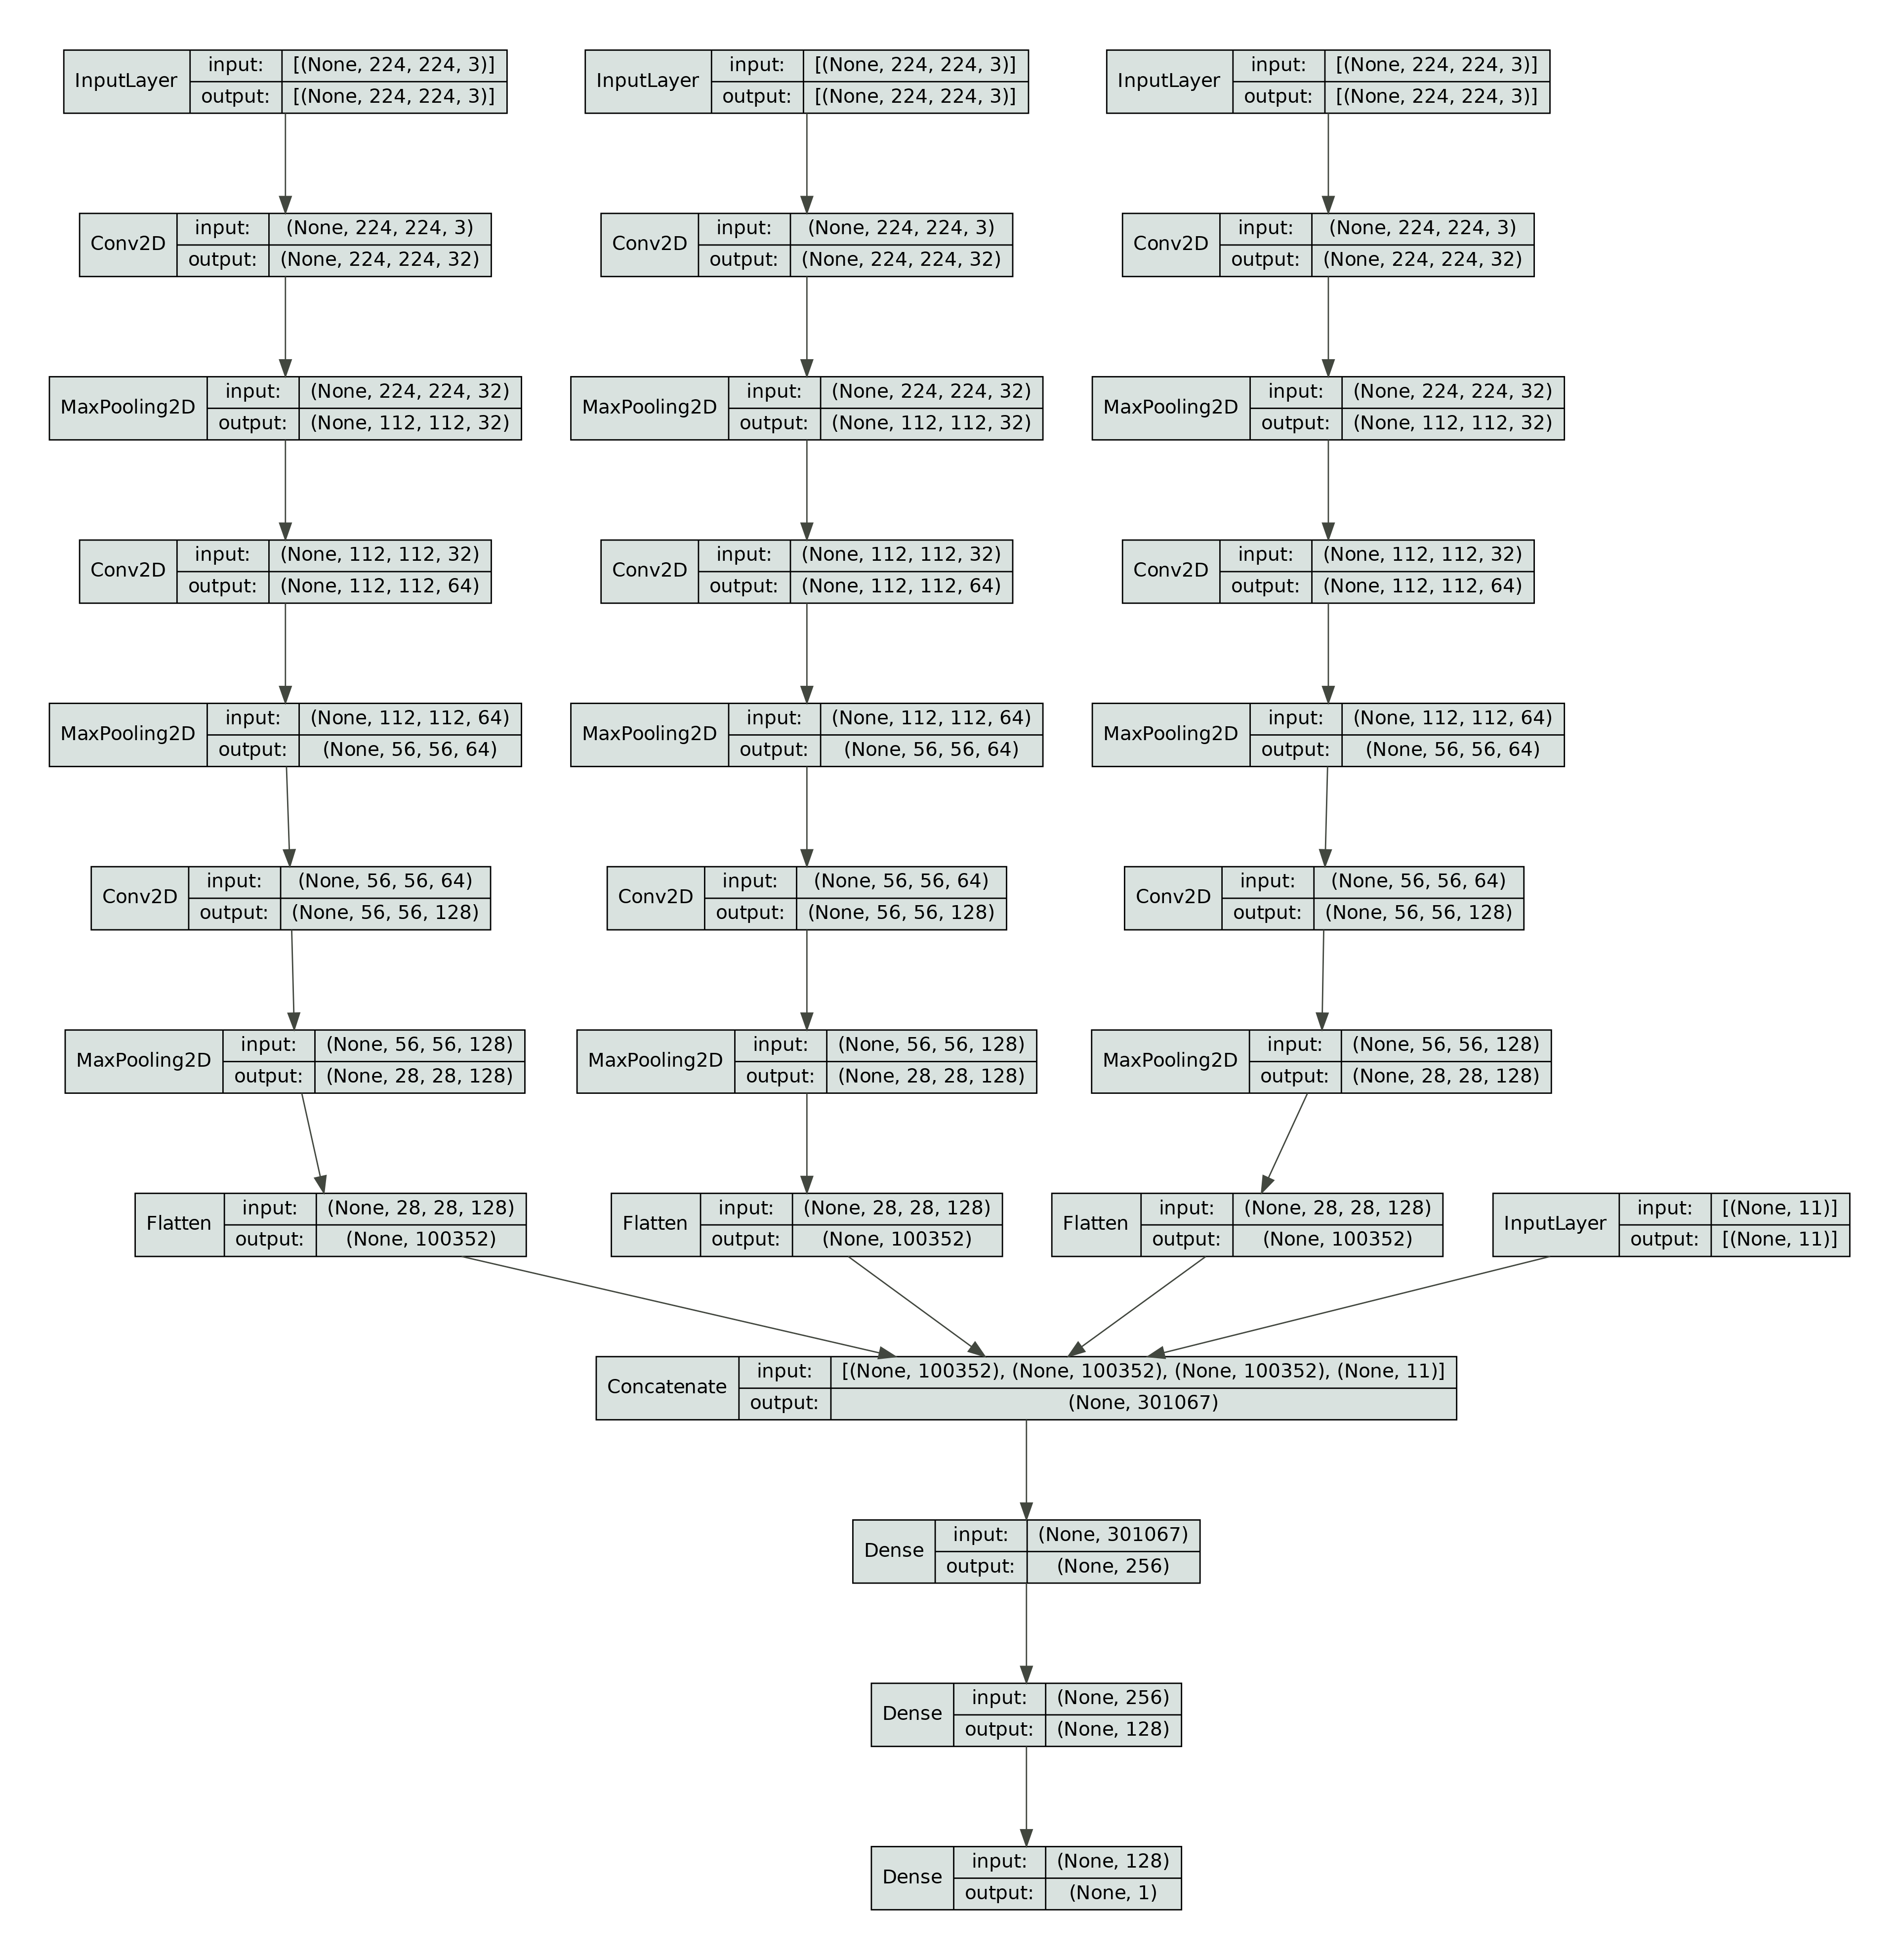

In [40]:
from keras.utils import model_to_dot
from IPython.display import Image

dot = model_to_dot(
    model,
    show_shapes=True,
    show_layer_names=False,
    rankdir='TB',
    dpi=200
)

for n in dot.get_nodes():

    n.set('style', 'filled')
    n.set('fillcolor', '#D9E2DF')
    n.set('fontname', 'Helvetica')

for e in dot.get_edges():

    e.set('color', '#42473F')
    e.set('arrowsize', '1.2')

dot.set_graph_defaults(
    bgcolor='#FFFFFF',
    pad='0.5',
    ranksep='1.0',
    nodesep='0.5'
)
dot.set_node_defaults(
    shape='box',
    style='filled',
    fillcolor='#D9E2DF',
    height='0.5',
    width='0.5',
    fontsize='10',
    color='#666666'
)
dot.set_edge_defaults(
    color='#D9E2DF',
    arrowsize='0.8',
    fontsize='10'
)

dot.write_png('architectures/model_2B_Architecture.png')
Image('architectures/model_2B_Architecture.png')

In [41]:
history = model.fit(
    
    x=train_generator,
    epochs=10,
    steps_per_epoch=len(trainGen1),
    validation_data=val_generator,
    validation_steps=len(valGen1),
    class_weight=class_weights_dict
)

Epoch 1/10


2024-04-06 16:07:19.130526: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-06 16:07:20.011483: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-06 16:07:21.613516: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-06 16:07:22.346883: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc0f3f34ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-06 16:07:22.346944: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-04-06 16:07:22.455651: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712405242.758095   29003 devic

2397/2397 [==============================] - 74s 27ms/step - loss: 6.2036 - accuracy: 0.7939 - val_loss: 0.2752 - val_accuracy: 0.8661
Epoch 2/10
2397/2397 [==============================] - 64s 27ms/step - loss: 0.3788 - accuracy: 0.8269 - val_loss: 0.2228 - val_accuracy: 0.8819
Epoch 3/10
2397/2397 [==============================] - 68s 28ms/step - loss: 0.3204 - accuracy: 0.8344 - val_loss: 0.2098 - val_accuracy: 0.9055
Epoch 4/10
2397/2397 [==============================] - 69s 29ms/step - loss: 0.8667 - accuracy: 0.8319 - val_loss: 0.2149 - val_accuracy: 0.8898
Epoch 5/10
2397/2397 [==============================] - 69s 29ms/step - loss: 0.2793 - accuracy: 0.8565 - val_loss: 0.1613 - val_accuracy: 0.9213
Epoch 6/10
2397/2397 [==============================] - 71s 30ms/step - loss: 0.2370 - accuracy: 0.8803 - val_loss: 0.1339 - val_accuracy: 0.9449
Epoch 7/10
2397/2397 [==============================] - 70s 29ms/step - loss: 0.2401 - accuracy: 0.8982 - val_loss: 0.1270 - val_accura

In [42]:
batchSize = 1 

def generate_evaluation_batches(image_gens, num_features, batch_size):

    while True:

        batches = [gen.next() for gen in image_gens]
        image_batches = [batch[0].astype(np.float32) for batch in batches]
        
        idx = (image_gens[0].batch_index - 1) * batch_size
        batch_index = np.arange(idx, min(idx + batch_size, len(num_features)))

        yield image_batches + [num_features[batch_index]], batches[0][1]


val_evaluation_generator = generate_evaluation_batches([valGen1, valGen2, valGen3], val_features, 1)

test_evaluation_generator = generate_evaluation_batches([testGen1, testGen2, testGen3], test_features, 1)

val_steps = len(val) // batchSize
test_steps = len(test) // batchSize

val_loss, val_accuracy = model.evaluate(val_evaluation_generator, steps=val_steps)
print('Validation accuracy:', val_accuracy)

test_loss, test_accuracy = model.evaluate(test_evaluation_generator, steps=test_steps)
print('Test accuracy:', test_accuracy)

127/127 [==============================] - 4s 30ms/step - loss: 0.0848 - accuracy: 0.9606
Validation accuracy: 0.960629940032959
281/281 [==============================] - 9s 32ms/step - loss: 0.0854 - accuracy: 0.9751
Test accuracy: 0.9750889539718628


In [43]:
import numpy as np
from sklearn.metrics import classification_report

predictions = model.predict(test_evaluation_generator, steps=test_steps)
predicted_classes = (predictions > 0.5).astype(int).flatten()

actual_labels = []
for _, labels in test_evaluation_generator:
    actual_labels.extend(labels)
    if len(actual_labels) >= test_steps * batchSize:
        break

actual_labels = np.array(actual_labels)[:len(predicted_classes)]

report = classification_report(actual_labels, predicted_classes)
print(report)

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(actual_labels, predicted_classes)
print(conf_matrix)

281/281 [==============================] - 8s 27ms/step
              precision    recall  f1-score   support

         0.0       0.77      0.79      0.78       214
         1.0       0.27      0.24      0.25        67

    accuracy                           0.66       281
   macro avg       0.52      0.52      0.52       281
weighted avg       0.65      0.66      0.66       281

[[170  44]
 [ 51  16]]


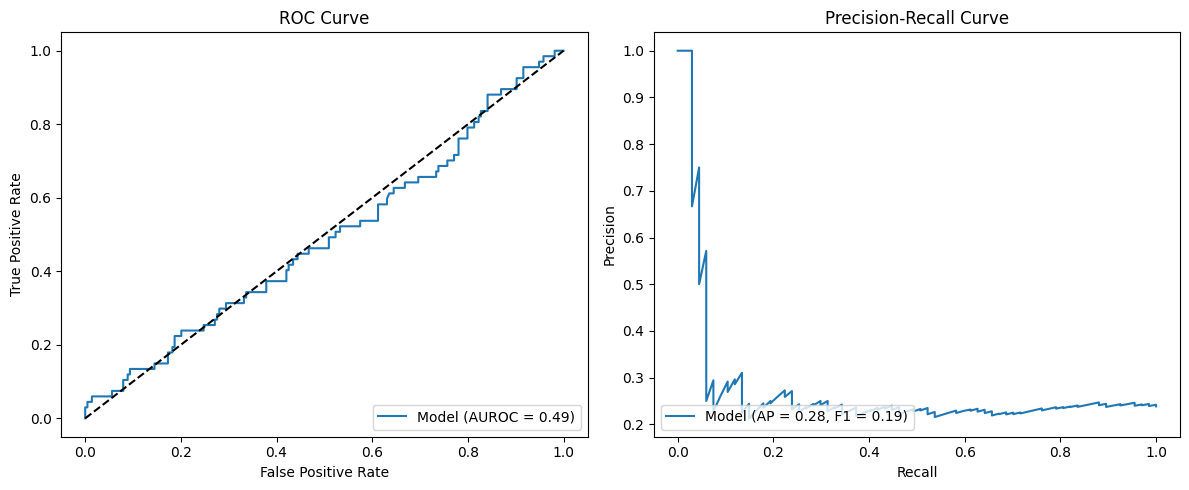

In [45]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score
import matplotlib.pyplot as plt

prob_positive_class = predictions

fpr, tpr, _ = roc_curve(actual_labels, prob_positive_class)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(actual_labels, prob_positive_class)
ap = average_precision_score(actual_labels, prob_positive_class)
threshold = 0.9
binary_predictions = [1 if prob >= threshold else 0 for prob in prob_positive_class]

f1 = f1_score(actual_labels, binary_predictions)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'Model (AUROC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'Model (AP = {ap:.2f}, F1 = {f1:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()